# Boston crime analysis for Head of Police

## imports

In [40]:
# Load the nbresult package to be able to save your results 
from nbresult import ChallengeResult

# Useful import for data collection
import sqlite3

# Useful imports for data manipulation and analysis
import numpy as np
import pandas as pd

# Useful imports for data visualisation
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from IPython.display import display

# Useful imports to estimate regression models
import statsmodels.formula.api as smf

## data preparation

In [5]:
data_district = pd.read_csv('data/boston_crimes_regression.csv')


In [6]:
# Load the dataset
from data import load_data_viz_data

data = load_data_viz_data()
data[['LAT','LONG']] = data[['LAT','LONG']].astype('float64')

print("Shape of the DataFrame:", data.shape)

data.head()

Shape of the DataFrame: (237221, 9)


,INCIDENT_NUMBER,OFFENSE_CODE_GROUP,SHOOTING,OCCURRED_ON_DATE,LAT,LONG,NAME,LAT_POLICE_STATION,LONG_POLICE_STATION
0,I192068249,Other,0,2015-08-28 10:20:00,42.330119,-71.084251,Roxbury,42.328894,-71.085359
1,I182074094,Violence and harassment,0,2015-09-14 09:31:00,42.315142,-71.067047,Roxbury,42.328894,-71.085359
2,I182054888,Violence and harassment,0,2015-07-12 15:37:00,42.312243,-71.075499,Roxbury,42.328894,-71.085359
3,I182054888,Other,0,2015-07-12 15:37:00,42.312243,-71.075499,Roxbury,42.328894,-71.085359
4,I182054888,Other,0,2015-07-12 15:37:00,42.312243,-71.075499,Roxbury,42.328894,-71.085359


In [20]:
def most_frequent (serie):
    '''
    take a serie as input and return the most frequent occurrence
    '''
    return serie.mode()[0]

most_frequent_df = data.groupby('NAME').agg({'OFFENSE_CODE_GROUP' : [most_frequent] })
most_frequent_df = most_frequent_df.reset_index()
most_frequent_df.columns = ['NAME', "MOST_FREQUENT_OFFENSE"]


In [8]:
# Haversine distance function
from math import radians, sin, cos, asin, sqrt

def haversine_distance(lon1, lat1, lon2, lat2):
    """
    Compute distance (km) between two pairs of (lat, lng) coordinates
    See - (https://en.wikipedia.org/wiki/Haversine_formula)
    """
    
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    
    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    
    return 2 * 6371 * asin(sqrt(a))

In [82]:
#compute the distance for each row first
distance_df = data.copy()

distance_df['distance'] = distance_df['LAT']
distance_df = distance_df[distance_df.LAT>0]
vect_haversine = np.vectorize(haversine_distance)
distance_df['distance'] = vect_haversine(distance_df.LONG,
                                                                           distance_df.LAT,
                                                                          distance_df.LONG_POLICE_STATION,
                                                                          distance_df.LAT_POLICE_STATION)
distance_df = distance_df.groupby('NAME').agg({'distance' : ['mean'],
                                               'LAT_POLICE_STATION' : 'first',
                                              'LONG_POLICE_STATION' : 'first'})
distance_df = distance_df.reset_index()
distance_df.columns = ['NAME', "AVG_DISTANCE", 'LAT', 'LONG']
distance_df

,NAME,AVG_DISTANCE,LAT,LONG
0,Brighton,1.314325,42.349300,-71.150600
1,Charlestown,1.942568,42.361800,-71.060300
2,Dorchester,1.373301,42.298068,-71.059141
3,Downtown,0.859035,42.361800,-71.060300
4,East Boston,1.204002,42.371200,-71.038700
5,Hyde Park,1.723354,42.256476,-71.124279
6,Jamaica Plain,1.263601,42.309700,-71.104600
7,Mattapan,1.311324,42.284800,-71.091600
8,Roxbury,1.465441,42.328894,-71.085359
9,South Boston,1.417177,42.341200,-71.054900


In [83]:
# merge in single dataframe
data_district_full = data_district.copy()
data_district_full = data_district_full.merge(distance_df,on='NAME')
data_district_full = data_district_full.merge(most_frequent_df, on='NAME')

In [84]:
data_district_full.sort_values('NB_INCIDENTS')

,MEDIAN_AGE,TOTAL_POP,PERC_OF_30_34,PERC_MARRIED_COUPLE_FAMILY,PER_CAPITA_INCOME,PERC_OTHER_STATE_OR_ABROAD,PERC_LESS_THAN_HIGH_SCHOOL,PERC_COLLEGE_GRADUATES,CODE,NB_INCIDENTS,NAME,AVG_DISTANCE,LAT,LONG,MOST_FREQUENT_OFFENSE
1,35.7,19890,28.2,36.4,75339,3.4,7.9,8.2,A15,4765,Charlestown,1.942568,42.361800,-71.060300,Larceny and vandalism
11,42.8,33526,18.1,46.2,47836,1.9,6.5,13.2,E5,9406,West Roxbury,2.170928,42.286800,-71.148400,Larceny and vandalism
4,30.6,47263,31.1,30.4,31473,3.5,27.2,11.5,A7,9691,East Boston,1.204002,42.371200,-71.038700,Larceny and vandalism
5,39.4,38924,21.1,38.4,32744,1.9,13.8,21.3,E18,12551,Hyde Park,1.723354,42.256476,-71.124279,Larceny and vandalism
6,34.8,40867,32.5,33.7,51655,5.5,8.0,12.1,E13,12802,Jamaica Plain,1.263601,42.309700,-71.104600,Larceny and vandalism
0,30.8,55297,52.8,26.4,41261,8.6,6.7,10.5,D14,13788,Brighton,1.314325,42.349300,-71.150600,Larceny and vandalism
9,31.9,36772,46.1,24.7,64745,2.4,7.9,8.4,C6,16617,South Boston,1.417177,42.341200,-71.054900,Larceny and vandalism
3,33.5,18306,32.5,35.8,80057,14.8,15.4,6.9,A1,26260,Downtown,0.859035,42.361800,-71.060300,Larceny and vandalism
7,36.7,26659,20.9,29.8,28356,2.3,14.5,22.9,B3,28331,Mattapan,1.311324,42.284800,-71.091600,Police investigation procedure
10,37.1,32571,33.9,28.3,83609,6.2,11.8,8.5,D4,31258,South End,1.320677,42.339629,-71.069161,Larceny and vandalism


## Viz

Geography viz  
time trend  
correlations  

In [30]:
data_district_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12 entries, 0 to 11
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   MEDIAN_AGE                  12 non-null     float64
 1   TOTAL_POP                   12 non-null     int64  
 2   PERC_OF_30_34               12 non-null     float64
 3   PERC_MARRIED_COUPLE_FAMILY  12 non-null     float64
 4   PER_CAPITA_INCOME           12 non-null     int64  
 5   PERC_OTHER_STATE_OR_ABROAD  12 non-null     float64
 6   PERC_LESS_THAN_HIGH_SCHOOL  12 non-null     float64
 7   PERC_COLLEGE_GRADUATES      12 non-null     float64
 8   CODE                        12 non-null     object 
 9   NB_INCIDENTS                12 non-null     int64  
 10  NAME                        12 non-null     object 
 11  AVG_DISTANCE                12 non-null     float64
 12  LAT                         12 non-null     float64
 13  LONG                        12 non-nu

# General overview

In [85]:
data_district_full['NB_INCIDENTS_OVER_POPULATION'] = data_district_full.NB_INCIDENTS / data_district_full.TOTAL_POP

In [86]:
data_district_full.sort_values('NB_INCIDENTS', ascending=False)[['NAME', 'NB_INCIDENTS', 'NB_INCIDENTS_OVER_POPULATION', 'MOST_FREQUENT_OFFENSE']].set_index('NAME')

,NB_INCIDENTS,NB_INCIDENTS_OVER_POPULATION,MOST_FREQUENT_OFFENSE
NAME,,,
Roxbury,38877,0.717804,Larceny and vandalism
Dorchester,32875,0.259044,Larceny and vandalism
South End,31258,0.959688,Larceny and vandalism
Mattapan,28331,1.062718,Police investigation procedure
Downtown,26260,1.434502,Larceny and vandalism
South Boston,16617,0.451893,Larceny and vandalism
Brighton,13788,0.249344,Larceny and vandalism
Jamaica Plain,12802,0.313260,Larceny and vandalism
Hyde Park,12551,0.322449,Larceny and vandalism


Map highlighting the district location with number of incidents with red circle and ratio of incident over total population.  
It can be seen that **Downtown** is standing out with high ratio and **Dorchester** with a low ratio (despite high total number of incidents).   
**Interactive Map below !**

## Interactive map

In [62]:
m = folium.Map((42.335142 ,-71.067047),zoom_start=12,width=500,height=500)
# folium.Marker(coordinates).add_to(m)
for i in range(len(data_district_full)):
    folium.Circle(location=[data_district_full.iloc[i]['LAT'], data_district_full.iloc[i]['LONG']],
      popup=data_district_full.iloc[i]['NAME'],
      radius=float(data_district_full.iloc[i]['NB_INCIDENTS']/50),
      color='crimson',
      fill=True,
      fill_color='crimson').add_to(m)
for i in range(len(data_district_full)):
    folium.Circle(location=[data_district_full.iloc[i]['LAT'], data_district_full.iloc[i]['LONG']],
      popup=data_district_full.iloc[i]['NAME'],
      radius=float(data_district_full.iloc[i]['NB_INCIDENTS_OVER_POPULATION']*800),
      color='blue',
      fill=True,
      fill_color='blue').add_to(m)
m

# Correlation with social environement

**We analyse how the family structure impact the incidents numbers and ratio**  
&emsp;&emsp;&emsp; Number of incidents on the left &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp; Ratio of incident over total population on the right  
_Note the blue cone showing the interval confidence which is very wide, so difficult to draw conclusions_

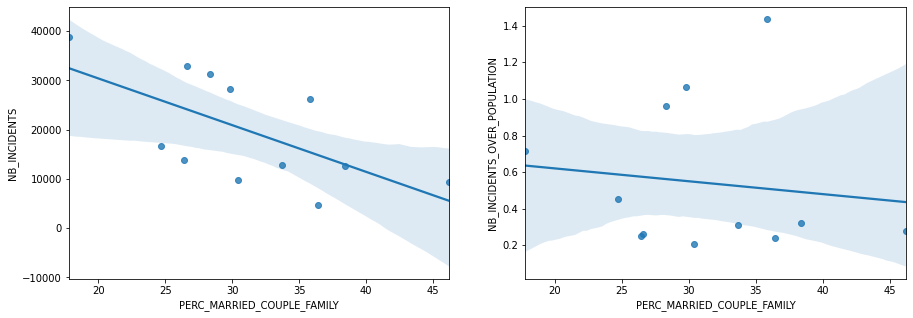

In [72]:
fig, ax = plt.subplots(1,2, figsize=(15,5))

sns.regplot(data = data_district_full, x='PERC_MARRIED_COUPLE_FAMILY', y = 'NB_INCIDENTS', ax=ax[0]);
sns.regplot(data = data_district_full, x='PERC_MARRIED_COUPLE_FAMILY', y = 'NB_INCIDENTS_OVER_POPULATION', ax=ax[1]);

**At first sight in the numbers, it seems that the more the population is made of couples, the less incidents there are, but actually looking at the ratio over total population tends to contradicts this**

**We analyse if migration impact the incidents numbers and ratio**  
&emsp;&emsp;&emsp; Number of incidents on the left &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp; Ratio of incident over total population on the right  
_Note the blue cone showing the interval confidence which is very wide, so difficult to draw conclusions_

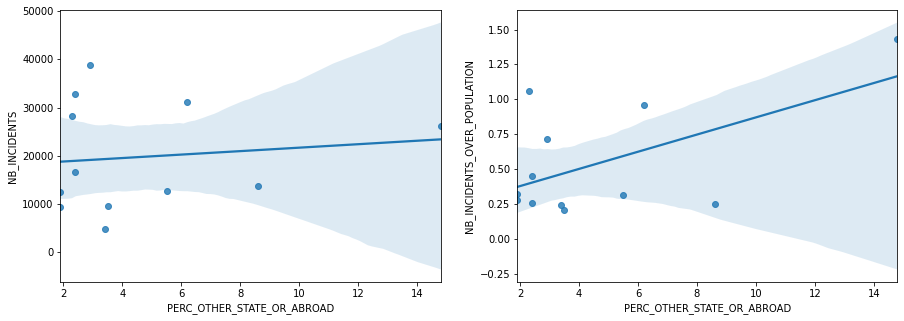

In [73]:
fig, ax = plt.subplots(1,2, figsize=(15,5))

sns.regplot(data = data_district_full, x='PERC_OTHER_STATE_OR_ABROAD', y = 'NB_INCIDENTS', ax=ax[0]);
sns.regplot(data = data_district_full, x='PERC_OTHER_STATE_OR_ABROAD', y = 'NB_INCIDENTS_OVER_POPULATION', ax=ax[1]);

**At first sight in the numbers, it seems that the has not so much impact on number of incidents, , but actually looking at the ratio over total population it seems that there is a positive correlation driven mainly by Downtown district**

# Impact of distance with Police station ?

**We analyse if the average distance from the police station to area of incidents impact the incidents numbers and ratio**  
&emsp;&emsp;&emsp; Number of incidents on the left &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp; Ratio of incident over total population on the right  
_Note the blue cone showing the interval confidence which is very wide, so difficult to draw conclusions_

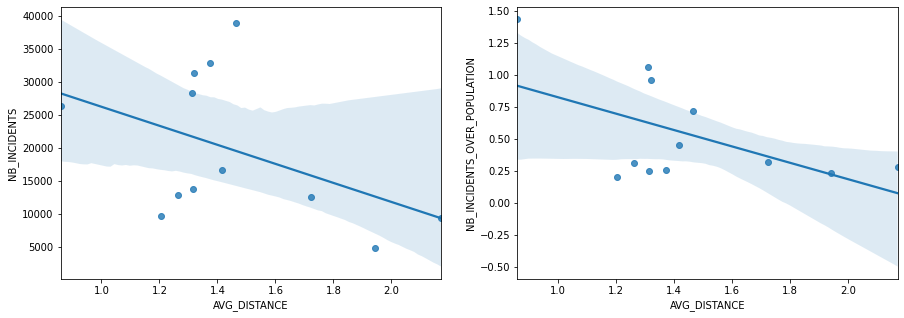

In [87]:
fig, ax = plt.subplots(1,2, figsize=(15,5))

sns.regplot(data = data_district_full, x='AVG_DISTANCE', y = 'NB_INCIDENTS', ax=ax[0]);
sns.regplot(data = data_district_full, x='AVG_DISTANCE', y = 'NB_INCIDENTS_OVER_POPULATION', ax=ax[1]);

**At first sight it seems that the longer the distance, the lower number and ratio of incidents!**  
But what we are probably seeing is that the distances are correlated with historical number of incidents, meaning that police offices have a tendency to get closer over time to area with higher number of incidents